In [17]:
import pandas as pd 
df = pd.read_csv("pricerunner_aggregate.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product ID       35311 non-null  int64 
 1   Product Title    35311 non-null  object
 2    Merchant ID     35311 non-null  int64 
 3    Cluster ID      35311 non-null  int64 
 4    Cluster Label   35311 non-null  object
 5    Category ID     35311 non-null  int64 
 6    Category Label  35311 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.9+ MB


,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


In [18]:
print(df.columns.tolist())
# Removing useless columns like Product ID. Remove Cluster ID and Cluster Label as they are the ground truths.abs
df = df.drop_duplicates(subset='Product Title')
df = df.drop(['Product ID', ' Cluster ID', ' Cluster Label'], axis=1)

from sklearn.feature_extraction.text import TfidfVectorizer

# tokenize the text, removes punctuation and stop wards (eg: "the", "and", "of"), build 5000 word bank
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_text = vectorizer.fit_transform(df['Product Title'].fillna(''))

['Product ID', 'Product Title', ' Merchant ID', ' Cluster ID', ' Cluster Label', ' Category ID', ' Category Label']


In [19]:
# Encode Categorical & Numeric Features
from sklearn.preprocessing import StandardScaler

# One-hot encode categorical features
X_cat = pd.get_dummies(df[[' Category Label', ' Merchant ID']], drop_first=True)

# Scale numeric columns 
scaler = StandardScaler()
X_cat_scaled = scaler.fit_transform(X_cat)

In [20]:
# Combine all features:
from scipy.sparse import hstack
X = hstack([X_text, X_cat_scaled])

In [21]:
# Run K-Means and K-Means++
from sklearn.cluster import KMeans
from sklearn import metrics
import time
from tqdm import tqdm

results = []

# Outer tqdm for progress bar
for k in tqdm([4, 6, 8, 10, 12, 16, 20], desc="Running K-Means experiments"):
    for init in ['random', 'k-means++']:
        start = time.time()
        kmeans = KMeans(n_clusters=k, init=init, n_init=10, random_state=42)
        kmeans.fit(X)
        end = time.time()
        
        inertia = kmeans.inertia_
        silhouette = metrics.silhouette_score(X, kmeans.labels_)
        runtime = end - start
        iterations = kmeans.n_iter_
        
        results.append([k, init, inertia, silhouette, runtime, iterations])

# Save results into a DataFrame
results_df = pd.DataFrame(results,columns=['k', 'init', 'inertia', 'silhouette', 'runtime', 'iterations'])

print(results_df)

Running K-Means experiments: 100%|████████████████| 7/7 [04:09<00:00, 35.63s/it]

     k       init        inertia  silhouette   runtime  iterations
0    4     random  234209.817161    0.249272  0.130141          11
1    4  k-means++  231406.140396    0.254226  0.180432           2
2    6     random  164634.976609    0.390861  0.131944           5
3    6  k-means++  163693.893756    0.395182  0.242120           2
4    8     random  109126.674803    0.469712  0.142824           6
5    8  k-means++   99135.109466    0.498091  0.321360           2
6   10     random   97097.519244    0.401783  0.202387           8
7   10  k-means++   51812.059767    0.533397  0.393712           3
8   12     random   48569.219384    0.457953  0.228900           8
9   12  k-means++   44150.338615    0.510786  0.476944           4
10  16     random   40631.091449    0.367271  0.398209          12
11  16  k-means++   34579.675636    0.462291  0.689531           5
12  20     random   32935.921461    0.314911  0.688572          10
13  20  k-means++   31107.184251    0.398339  0.905972        

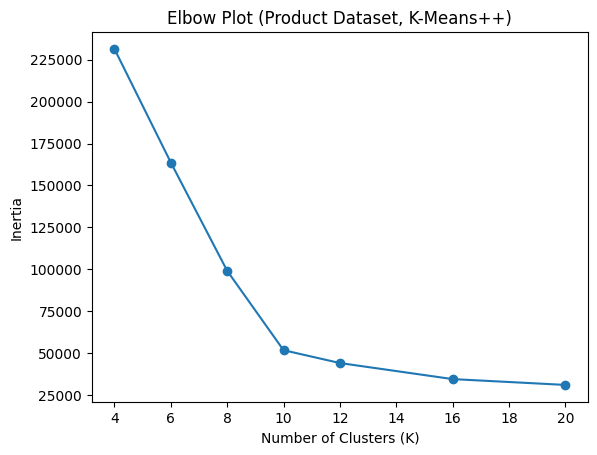

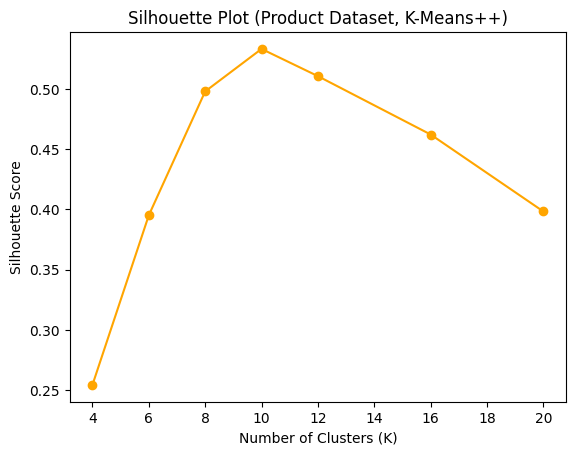

In [22]:
import matplotlib.pyplot as plt

# Elbow Plot
plt.plot(results_df[results_df['init']=='k-means++']['k'], results_df[results_df['init']=='k-means++']['inertia'], marker='o')
plt.title('Elbow Plot (Product Dataset, K-Means++)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# Silhouette Plot
plt.plot(results_df[results_df['init']=='k-means++']['k'], results_df[results_df['init']=='k-means++']['silhouette'], marker='o', color='orange')
plt.title('Silhouette Plot (Product Dataset, K-Means++)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

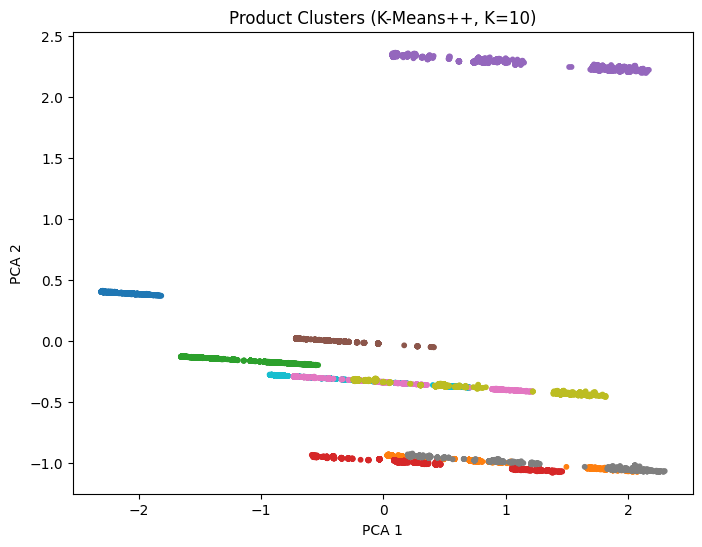

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

# Fit final model with optimal K=10
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state=42)
kmeans.fit(X)

# Plot clusters in 2D PCA space
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels_, cmap='tab10', s=10)
plt.title('Product Clusters (K-Means++, K=10)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

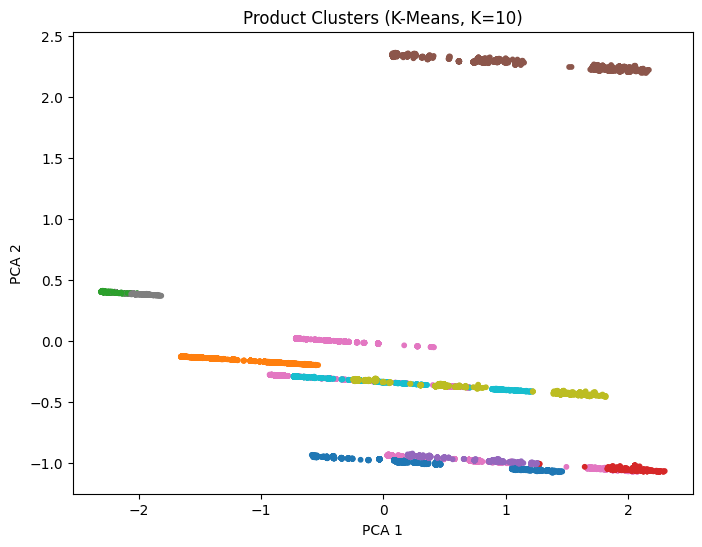

In [24]:
# Do the same but for K-means this time
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

# Fit final model with optimal K=10
kmeans = KMeans(n_clusters=10, init='random', n_init=10, random_state=42)
kmeans.fit(X)

# Plot clusters in 2D PCA space
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels_, cmap='tab10', s=10)
plt.title('Product Clusters (K-Means, K=10)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()